<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/homogen-classification-GCN-Mk.-1/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this model, the data surrounds team A and B, where A always wins.

The data is stored in a Heterogeneus graph.
A node is a team and it's feature is it's past win/loss ratio.
An edge represents a match. For each match there are 2 edges. It represents the result, from the originating node teams point of view. Meaning that if the number is negative, they lost. The absolute value is the difference in gols.

To predict the result, we use a GCN evalueate all teams, concatinate these evaluations in acordance with the edge we are trying to predict (originating node team is first) and then do a linear regression to get a single value, which is the result.

# Setup

In [1]:
!pip install -q torch==2.4.0

import os
import torch

os.environ['TORCH'] = torch.__version__

!pip install -q pyg_lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_geometric -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torcheval
!pip install -q scikit-plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Imports

In [2]:
import json
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics as M
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
%matplotlib inline

# Data definition

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

win_value = 1.0
loss_value = -1.0
tie_value = (win_value + loss_value)/2

numTrainMatches = 700
numValMatches = 300

# Learning

In [4]:
epochs = 150

lr = 0.001
dropout_p = 0.0
Diff = True
Tie = True
crit = torch.nn.MSELoss()

# Data: team A always wins

In [5]:
data = Data()
data.x = torch.Tensor(
    [[1.0],
     [0.0]]
)
data.edge_index = torch.Tensor(
    [[0, 1]*(numTrainMatches + numValMatches),
     [1, 0]*(numTrainMatches + numValMatches)]
).type(torch.long)
data.edge_attr = torch.Tensor(
    [[win_value, loss_value]*(numTrainMatches + numValMatches)]
)
data.edge_weight = torch.Tensor(
    [1, 1]*(numTrainMatches + numValMatches)
)

data.train_mask = torch.Tensor(
    [[True]*2*numTrainMatches + [False]*2*numValMatches]
).type(torch.bool)
data.val_mask = torch.Tensor(
    [[False]*2*numTrainMatches + [True]*2*numValMatches]
).type(torch.bool)

In [6]:
def plotLoss(loss_data: list[float]):
  plt.plot(range(len(loss_data)), loss_data)
  plt.show()

# Model

In [7]:
class model(torch.nn.Module):
  def __init__(self, channels: list[int], device: str='cpu', dropout: float=0.0):
    assert len(channels) >= 2

    super().__init__()

    self.device = device
    self.dropout = dropout

    self.gcn = torch.nn.ModuleList()
    for i in range(len(channels) - 1):
      self.gcn.append(nn.GCNConv(channels[i], channels[i+1], add_self_loops=False))
    self.gcn.to(self.device)

    self.lin = torch.nn.Linear(channels[-1]*2, 1).to(self.device)

  def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_weight: torch.Tensor) -> torch.Tensor:
    # move data to device
    x = x.to(self.device)
    edge_index = edge_index.to(self.device)
    edge_weight = edge_weight.to(self.device)

    # calculate values for each team
    for module in self.gcn:
      x = module(x, edge_index, edge_weight)
      x = x.relu()
      x = F.dropout(x, p=self.dropout, training=self.training)

    # create match vectors by combining teams that played
    x_1st = x[edge_index[0]]
    x_2nd = x[edge_index[1]]
    lin_input = torch.cat((x_1st, x_2nd), dim=1)

    # calculate result from match vector
    x = self.lin(lin_input)

    return x.T

# Learn

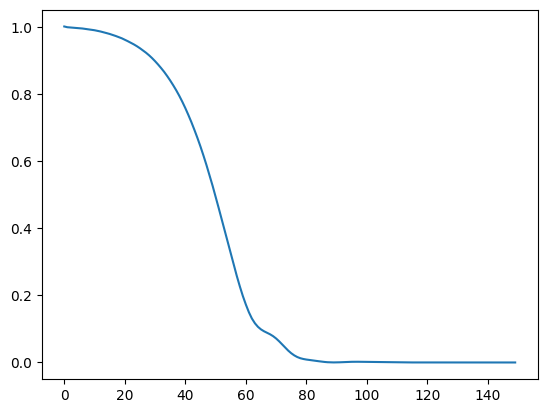

In [8]:
gcn = model([1] + [32]*5 + [16], device=device, dropout=dropout_p)
gcn.to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

loss_values = []

for epoch in range(epochs):
  # prepare model for training
  gcn.train()
  optimizer.zero_grad()

  # prepare train data
  train_mask = torch.reshape(data.train_mask, (-1,))
  x = data.x
  edge_index = data.edge_index[:, train_mask]
  edge_weight = data.edge_weight[train_mask]

  # train
  pred = gcn(x, edge_index, edge_weight).to(device)

  # prepare validation data
  ground_truth = data.edge_attr[:, train_mask].to(device)
  ground_truth.requires_grad = True

  # calculate loss
  loss = crit(pred, ground_truth)
  loss_values.append(loss.item())
  loss.backward()
  optimizer.step()

# draw loss
plotLoss(loss_values)

# Evaluate

In [18]:
gcn.eval()

val_mask = torch.reshape(data.val_mask, (-1,))
x = data.x
edge_index = data.edge_index[:, val_mask]
edge_weight = data.edge_weight[val_mask]

pred = gcn(x, edge_index, edge_weight).to(device).T
class_pred = (torch.where(pred >= tie_value, win_value, loss_value) + 1)/2

ground_truth = data.edge_attr[:, val_mask].to(device).T
ground_truth.requires_grad = True
class_ground_truth = (ground_truth + 1)/2

R2 = M.R2Score()
R2.to(device)
R2.update(pred, ground_truth)
print(f"R2: {R2.compute()}")

MSE = M.MeanSquaredError()
MSE.to(device)
MSE.update(pred, ground_truth)
print(f"MSE: {MSE.compute()}")

BiAcc = M.BinaryAccuracy()
BiAcc.to(device)
BiAcc.update(torch.reshape(class_pred, (-1,)), torch.reshape(class_ground_truth, (-1,)))
print(f"BiAcc: {BiAcc.compute()}")

R2: 0.9999992847442627
MSE: 7.054595698718913e-07
BiAcc: 1.0
